# With the new control and armflapping videos (shorter directories), let's see whether we can get a higher accuracy. 

In [1]:
import cv2, os 
import numpy as np 
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp


def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1; 
    locations = np.concatenate([X_locations, Y_locations, Z_locations])
    hands.close()
    return locations 

In [3]:
# time to actually do calibration. 

SECONDS_TO_DETECT = 2 # in seconds
DISTANCE_BETWEEN_INPUTS = 0.01 # in seconds, only matters if sampling is True
sampling = False 

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

armflapping_videos:  19%|█▊        | 20/108 [00:00<00:02, 33.32it/s]

failed on .DS_Store


control_videos:  24%|██▍       | 15/62 [00:00<00:02, 15.85it/s]

failed on .DS_Store


control_videos: 100%|██████████| 62/62 [00:05<00:00, 10.65it/s]


(97, 50)

In [4]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 50/50 [01:48<00:00,  2.17s/it]


In [5]:
print([len(video) for video in ARMFLAPPING_LOCATIONS])
print([len(video) for video in CONTROL_LOCATIONS])

[121, 61, 121, 90, 90, 90, 72, 90, 90, 49, 49, 90, 90, 90, 72, 90, 121, 49, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 121, 90, 90, 90, 90, 91, 90, 120, 90, 90, 121, 91, 90, 90, 90, 90, 45, 45, 121, 90, 90, 45, 90, 72, 60, 90, 90, 91, 91, 49, 91, 121, 90, 90, 72, 90, 72, 72, 49, 49, 90, 45, 72, 72, 120, 121, 90, 90, 72, 90, 90, 49, 72, 45, 72, 91, 90, 90, 97, 121, 49, 45, 72, 73, 60, 72, 90, 72]
[121, 121, 90, 90, 72, 72, 90, 91, 49, 49, 49, 61, 45, 72, 72, 72, 73, 90, 60, 121, 90, 49, 90, 90, 73, 90, 73, 49, 121, 90, 90, 90, 60, 90, 121, 90, 41, 121, 45, 60, 121, 90, 90, 121, 90, 61, 46, 45, 45, 121]


In [5]:
# to balance classes 
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

In [6]:
# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = np.array(locations).tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

50it [00:00, 17415.31it/s]
50it [00:00, 7727.73it/s]

(50, 90, 126) (50, 90, 126)


In [7]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 
X, y = generate_data(padded_armflapping_locations, padded_control_locations)

In [9]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)

    test_frames = np.array([test_frames])
    test_frames = pad(test_frames, maxlen = 90)
    
    return model.predict(test_frames)

In [10]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X


class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X):
        return tf.map_fn(_shift, X)
        
        

In [11]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('all_points_folds'): 
    with open(f"all_points_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [12]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")
        
    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.show() 

In [13]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        M = np.random.permutation(X_train.shape[0])
        X_train, y_train = X_train[M], y_train[M]

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")
    plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 

In [21]:
def shuffle(X, y): 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 126)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y)

In [15]:
import tensorflow as tf 
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(),
        tf.keras.layers.LSTM(64, return_sequences=False), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

Epoch 1/75
3/3 [==============================] - 1s 235ms/step - loss: 0.7001 - accuracy: 0.4375 - precision_17: 0.4464 - recall_17: 0.6410 - val_loss: 0.6854 - val_accuracy: 0.5000 - val_precision_17: 0.5294 - val_recall_17: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6682 - accuracy: 0.6625 - precision_17: 0.6250 - recall_17: 0.7692 - val_loss: 0.6765 - val_accuracy: 0.7000 - val_precision_17: 0.7778 - val_recall_17: 0.6364
Epoch 3/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6529 - accuracy: 0.7000 - precision_17: 0.6531 - recall_17: 0.8205 - val_loss: 0.6697 - val_accuracy: 0.7000 - val_precision_17: 0.7778 - val_recall_17: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6371 - accuracy: 0.7625 - precision_17: 0.7083 - recall_17: 0.8718 - val_loss: 0.6629 - val_accuracy: 0.7000 - val_precision_17: 0.7778 - val_recall_17: 0.6364
Epoch 5/75
3/3 [==============================] - 0s 153ms/step 

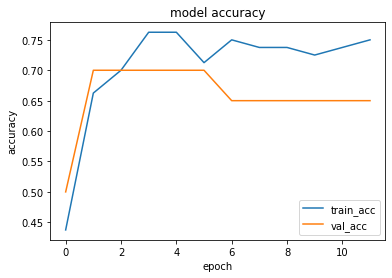

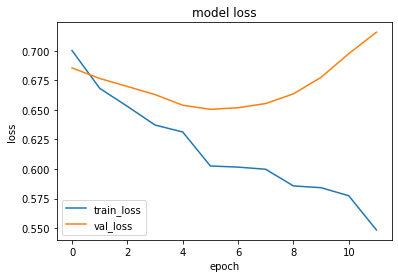

1it [00:00, 19239.93it/s]


prediction for video armflapping_1.mov is [[0.48233446]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.50678253]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_2.mov is [[0.47771955]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.34033367]]


1it [00:00, 20763.88it/s]


prediction for video control_2.mov is [[0.54318273]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.40510178]]
Epoch 1/75
3/3 [==============================] - 1s 252ms/step - loss: 0.7206 - accuracy: 0.4375 - precision_18: 0.3333 - recall_18: 0.0976 - val_loss: 0.6899 - val_accuracy: 0.3000 - val_precision_18: 0.2222 - val_recall_18: 0.2222
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6886 - accuracy: 0.4750 - precision_18: 0.4898 - recall_18: 0.5854 - val_loss: 0.6853 - val_accuracy: 0.5000 - val_precision_18: 0.4737 - val_recall_18: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 177ms/step - loss: 0.6615 - accuracy: 0.5375 - precision_18: 0.5278 - recall_18: 0.9268 - val_loss: 0.6824 - val_accuracy: 0.5000 - val_precision_18: 0.4737 - val_recall_18: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6486 - accuracy: 0.5750 - precision_18: 0.5479 - recall_18: 0.9756 - val_loss: 0.6787 - val_accuracy: 0.5000 - val_precision_18: 0.4737 - val_recall_18: 1.0000
Epoch 5/75


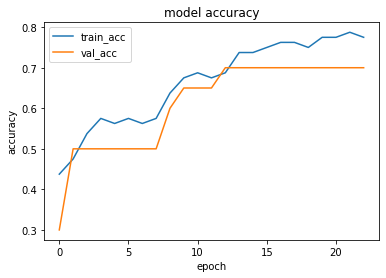

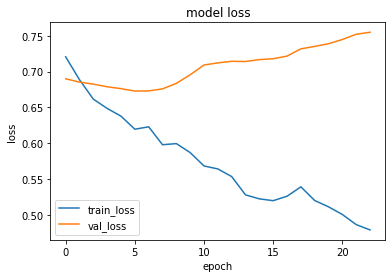

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.84194696]]


1it [00:00, 12671.61it/s]


prediction for video armflapping_3.mov is [[0.59537566]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.5457995]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.0575884]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.918776]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.3994885]]
Epoch 1/75
3/3 [==============================] - 1s 264ms/step - loss: 0.7034 - accuracy: 0.5875 - precision_19: 0.5500 - recall_19: 0.8462 - val_loss: 0.6559 - val_accuracy: 0.7000 - val_precision_19: 0.6471 - val_recall_19: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6968 - accuracy: 0.6375 - precision_19: 0.6136 - recall_19: 0.6923 - val_loss: 0.6564 - val_accuracy: 0.8000 - val_precision_19: 0.7692 - val_recall_19: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6662 - accuracy: 0.7375 - precision_19: 0.7368 - recall_19: 0.7179 - val_loss: 0.6558 - val_accuracy: 0.7500 - val_precision_19: 0.7500 - val_recall_19: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6737 - accuracy: 0.7000 - precision_19: 0.7027 - recall_19: 0.6667 - val_loss: 0.6660 - val_accuracy: 0.7000 - val_precision_19: 0.7778 - val_recall_19: 0.6364
Epoch 5/75
3

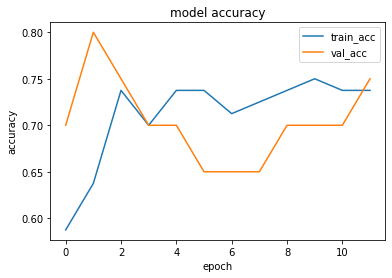

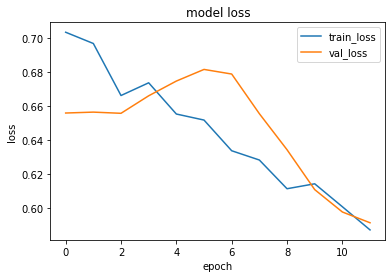

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.5069248]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.4988023]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.49360594]]


1it [00:00, 19152.07it/s]


prediction for video control_1.mov is [[0.4645243]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.5377137]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.49181056]]
Epoch 1/75
3/3 [==============================] - 1s 255ms/step - loss: 0.7156 - accuracy: 0.4000 - precision_20: 0.3333 - recall_20: 0.1429 - val_loss: 0.6805 - val_accuracy: 0.3500 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 168ms/step - loss: 0.6938 - accuracy: 0.4375 - precision_20: 0.4651 - recall_20: 0.4762 - val_loss: 0.6823 - val_accuracy: 0.5500 - val_precision_20: 0.4706 - val_recall_20: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6904 - accuracy: 0.5625 - precision_20: 0.5522 - recall_20: 0.8810 - val_loss: 0.6845 - val_accuracy: 0.5500 - val_precision_20: 0.4706 - val_recall_20: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6879 - accuracy: 0.4500 - precision_20: 0.4861 - recall_20: 0.8333 - val_loss: 0.6768 - val_accuracy: 0.5500 - val_precision_20: 0.4706 - val_recall_20: 1.0000
Epo

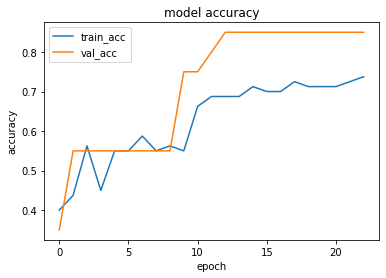

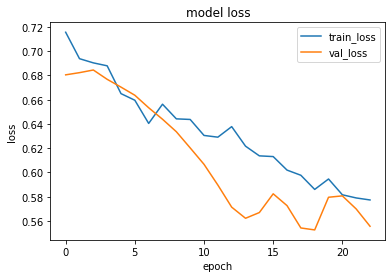

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.4018513]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5226651]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.3308852]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.20562354]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.73741615]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.2543466]]
Epoch 1/75
3/3 [==============================] - 1s 237ms/step - loss: 0.6853 - accuracy: 0.4500 - precision_21: 0.4490 - recall_21: 0.5641 - val_loss: 0.6835 - val_accuracy: 0.6000 - val_precision_21: 0.5789 - val_recall_21: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6551 - accuracy: 0.5750 - precision_21: 0.5373 - recall_21: 0.9231 - val_loss: 0.6826 - val_accuracy: 0.6000 - val_precision_21: 0.5789 - val_recall_21: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6432 - accuracy: 0.6125 - precision_21: 0.5606 - recall_21: 0.9487 - val_loss: 0.6765 - val_accuracy: 0.6000 - val_precision_21: 0.6000 - val_recall_21: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6287 - accuracy: 0.7250 - precision_21: 0.6667 - recall_21: 0.8718 - val_loss: 0.6711 - val_accuracy: 0.6000 - val_precision_21: 0.6000 - val_recall_21: 0.8182
Epoch 5/75
3

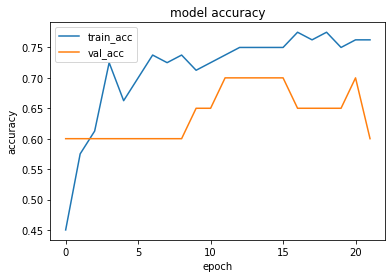

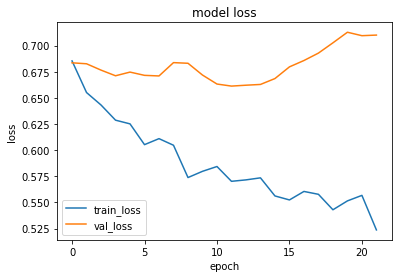

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.3774614]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5735576]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.3043787]]


1it [00:00, 16710.37it/s]


prediction for video control_1.mov is [[0.11492121]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.9092401]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.22873807]]


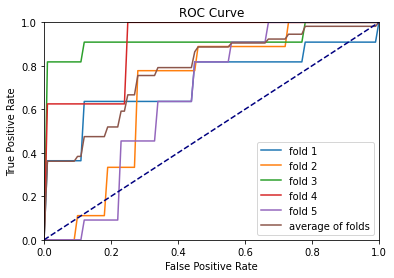

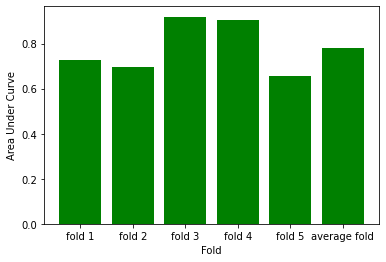

In [25]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 249ms/step - loss: 0.7199 - accuracy: 0.3875 - precision_25: 0.4167 - recall_25: 0.6410 - val_loss: 0.6834 - val_accuracy: 0.5500 - val_precision_25: 0.5500 - val_recall_25: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6832 - accuracy: 0.6375 - precision_25: 0.5862 - recall_25: 0.8718 - val_loss: 0.6803 - val_accuracy: 0.6500 - val_precision_25: 0.7000 - val_recall_25: 0.6364
Epoch 3/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6683 - accuracy: 0.7000 - precision_25: 0.6744 - recall_25: 0.7436 - val_loss: 0.6808 - val_accuracy: 0.6500 - val_precision_25: 0.7500 - val_recall_25: 0.5455
Epoch 4/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6549 - accuracy: 0.6625 - precision_25: 0.6500 - recall_25: 0.6667 - val_loss: 0.6714 - val_accuracy: 0.7000 - val_precision_25: 0.7778 - val_recall_25: 0.6364
Epoch 5/75
3/3 [==============================] - 0s 160ms/step 

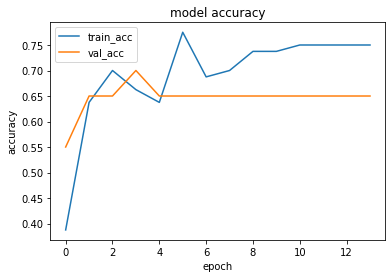

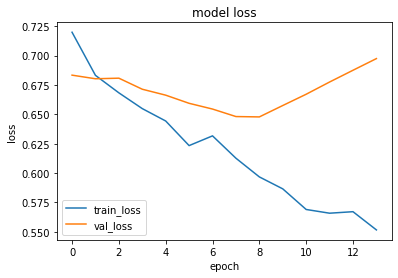

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.45355433]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.5098523]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.3960088]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.28435355]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.57900465]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.34630662]]
Epoch 1/75
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/backend.py", line 4518, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
3/3 [==============================] - 1s 216ms/step - loss: 0.6767 - accuracy: 0.6750 - precision_26: 0.6364 - recall_26: 0.8537 - val_loss: 0.6852 - val_accuracy: 0.6500 - val_precision_26: 0.5714 - val_recall_26: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 14

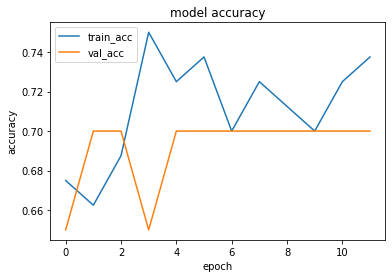

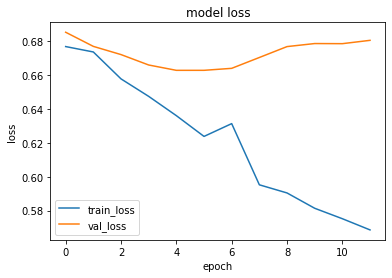

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.34189332]]


1it [00:00, 4462.03it/s]


prediction for video armflapping_3.mov is [[0.57614726]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_2.mov is [[0.22845224]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.11671674]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.82840675]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.21857631]]
Epoch 1/75
3/3 [==============================] - 1s 268ms/step - loss: 0.6957 - accuracy: 0.4875 - precision_27: 0.4583 - recall_27: 0.2821 - val_loss: 0.7095 - val_accuracy: 0.2500 - val_precision_27: 0.2500 - val_recall_27: 0.1818
Epoch 2/75
3/3 [==============================] - 0s 163ms/step - loss: 0.6758 - accuracy: 0.5250 - precision_27: 0.5111 - recall_27: 0.5897 - val_loss: 0.6836 - val_accuracy: 0.4000 - val_precision_27: 0.4615 - val_recall_27: 0.5455
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6762 - accuracy: 0.5000 - precision_27: 0.4918 - recall_27: 0.7692 - val_loss: 0.6600 - val_accuracy: 0.5000 - val_precision_27: 0.5333 - val_recall_27: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6679 - accuracy: 0.5250 - precision_27: 0.5072 - recall_27: 0.8974 - val_loss: 0.6456 - val_accuracy: 0.5000 - val_precision_27: 0.5333 - val_recall_27: 0.7273
Epoch 5/75


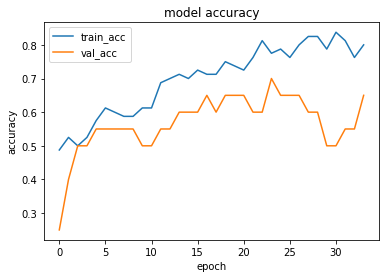

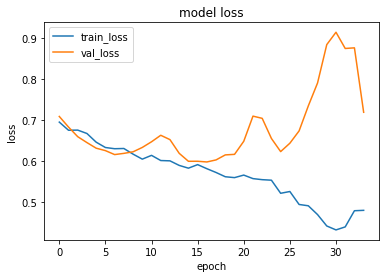

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.87105095]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.62969416]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.671253]]


1it [00:00, 18808.54it/s]


prediction for video control_1.mov is [[0.03195027]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.40758958]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.70389783]]
Epoch 1/75
3/3 [==============================] - 1s 235ms/step - loss: 0.6926 - accuracy: 0.4125 - precision_28: 0.4286 - recall_28: 0.3571 - val_loss: 0.6678 - val_accuracy: 0.5000 - val_precision_28: 0.4444 - val_recall_28: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6625 - accuracy: 0.5625 - precision_28: 0.5507 - recall_28: 0.9048 - val_loss: 0.6770 - val_accuracy: 0.5000 - val_precision_28: 0.4444 - val_recall_28: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6661 - accuracy: 0.5625 - precision_28: 0.5455 - recall_28: 1.0000 - val_loss: 0.6799 - val_accuracy: 0.5000 - val_precision_28: 0.4444 - val_recall_28: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6624 - accuracy: 0.5625 - precision_28: 0.5467 - recall_28: 0.9762 - val_loss: 0.6712 - val_accuracy: 0.5000 - val_precision_28: 0.4444 - val_recall_28: 1.0000
Epoch 5/75


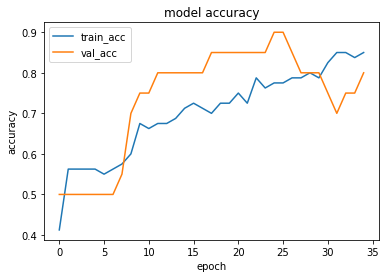

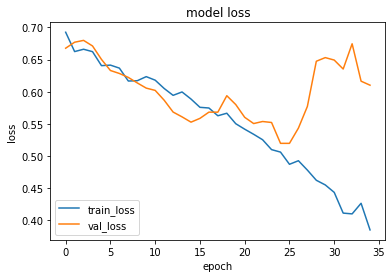

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.7601547]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_3.mov is [[0.53291494]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_2.mov is [[0.6992498]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.02215618]]


1it [00:00, 20867.18it/s]


prediction for video control_2.mov is [[0.69837505]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.9272125]]
Epoch 1/75
3/3 [==============================] - 1s 268ms/step - loss: 0.6885 - accuracy: 0.4500 - precision_29: 0.4419 - recall_29: 0.4872 - val_loss: 0.6820 - val_accuracy: 0.6000 - val_precision_29: 0.5789 - val_recall_29: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6729 - accuracy: 0.5250 - precision_29: 0.5077 - recall_29: 0.8462 - val_loss: 0.6899 - val_accuracy: 0.6000 - val_precision_29: 0.5789 - val_recall_29: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6541 - accuracy: 0.5875 - precision_29: 0.5441 - recall_29: 0.9487 - val_loss: 0.6949 - val_accuracy: 0.6000 - val_precision_29: 0.6000 - val_recall_29: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6346 - accuracy: 0.6875 - precision_29: 0.6296 - recall_29: 0.8718 - val_loss: 0.6963 - val_accuracy: 0.6000 - val_precision_29: 0.6000 - val_recall_29: 0.8182
Epoch 5/75
3

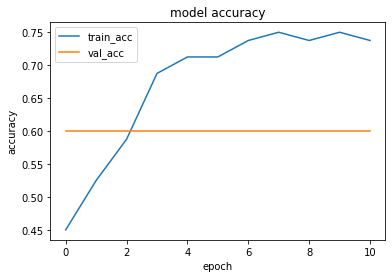

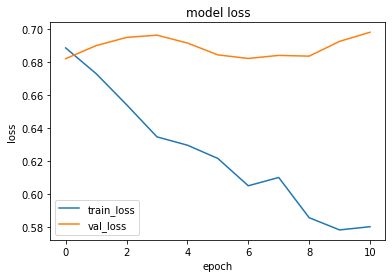

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.38520163]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.6182727]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.26188314]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.13260946]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.89174485]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.21250865]]


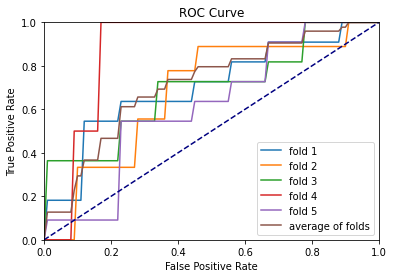

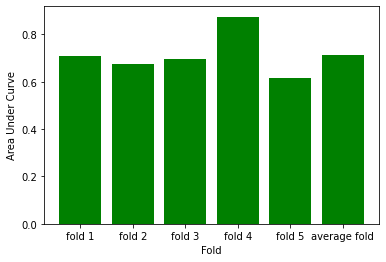

In [27]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 332ms/step - loss: 0.6882 - accuracy: 0.5750 - precision_31: 0.5581 - recall_31: 0.6154 - val_loss: 0.6865 - val_accuracy: 0.8000 - val_precision_31: 0.8889 - val_recall_31: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6784 - accuracy: 0.7000 - precision_31: 0.6596 - recall_31: 0.7949 - val_loss: 0.6757 - val_accuracy: 0.7500 - val_precision_31: 0.8000 - val_recall_31: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6687 - accuracy: 0.6750 - precision_31: 0.6275 - recall_31: 0.8205 - val_loss: 0.6675 - val_accuracy: 0.7000 - val_precision_31: 0.7778 - val_recall_31: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6484 - accuracy: 0.6750 - precision_31: 0.6226 - recall_31: 0.8462 - val_loss: 0.6570 - val_accuracy: 0.6500 - val_precision_31: 0.7000 - val_recall_31: 0.6364
Epoch 5/75
3/3 [==============================] - 0s 148ms/step 

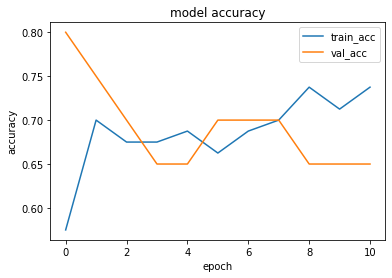

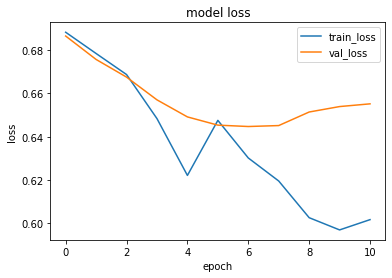

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.5086051]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.50442487]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.51393]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.43481216]]


1it [00:00, 20460.02it/s]


prediction for video control_2.mov is [[0.5074399]]


1it [00:00, 19239.93it/s]


prediction for video control_3.mov is [[0.43759593]]
Epoch 1/75
3/3 [==============================] - 1s 217ms/step - loss: 0.6834 - accuracy: 0.5500 - precision_32: 0.5532 - recall_32: 0.6341 - val_loss: 0.6798 - val_accuracy: 0.5500 - val_precision_32: 0.5000 - val_recall_32: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6737 - accuracy: 0.5625 - precision_32: 0.5517 - recall_32: 0.7805 - val_loss: 0.6770 - val_accuracy: 0.5000 - val_precision_32: 0.4706 - val_recall_32: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6589 - accuracy: 0.6125 - precision_32: 0.5893 - recall_32: 0.8049 - val_loss: 0.6739 - val_accuracy: 0.7000 - val_precision_32: 0.6364 - val_recall_32: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6354 - accuracy: 0.7125 - precision_32: 0.6800 - recall_32: 0.8293 - val_loss: 0.6709 - val_accuracy: 0.7000 - val_precision_32: 0.6364 - val_recall_32: 0.7778
Epoch 5/75


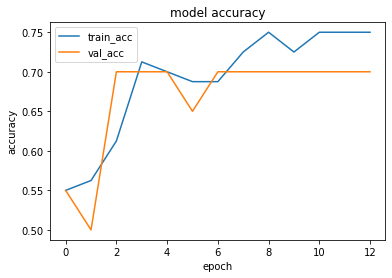

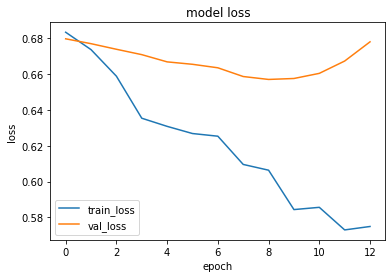

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.34001756]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.57922614]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.14521533]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.08404222]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.8443693]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.19089577]]
Epoch 1/75
3/3 [==============================] - 1s 227ms/step - loss: 0.7112 - accuracy: 0.4375 - precision_33: 0.4464 - recall_33: 0.6410 - val_loss: 0.6727 - val_accuracy: 0.6500 - val_precision_33: 0.6250 - val_recall_33: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6904 - accuracy: 0.4750 - precision_33: 0.4754 - recall_33: 0.7436 - val_loss: 0.6804 - val_accuracy: 0.5000 - val_precision_33: 0.5455 - val_recall_33: 0.5455
Epoch 3/75
3/3 [==============================] - 1s 237ms/step - loss: 0.6874 - accuracy: 0.4750 - precision_33: 0.4706 - recall_33: 0.6154 - val_loss: 0.6801 - val_accuracy: 0.4500 - val_precision_33: 0.5000 - val_recall_33: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6739 - accuracy: 0.6875 - precision_33: 0.6458 - recall_33: 0.7949 - val_loss: 0.6896 - val_accuracy: 0.5000 - val_precision_33: 0.5455 - val_recall_33: 0.5455
Epoch 5/75


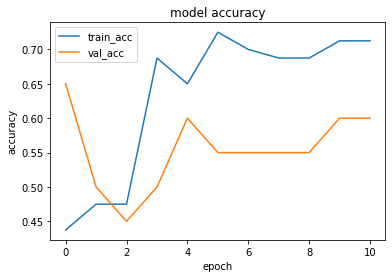

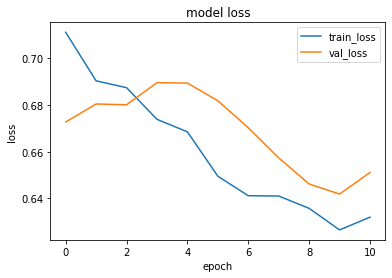

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.4291696]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.53853375]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.30878645]]


1it [00:00, 18808.54it/s]


prediction for video control_1.mov is [[0.12062043]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.6797896]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.16871166]]
Epoch 1/75
3/3 [==============================] - 1s 230ms/step - loss: 0.6934 - accuracy: 0.4625 - precision_34: 0.4898 - recall_34: 0.5714 - val_loss: 0.6665 - val_accuracy: 0.5500 - val_precision_34: 0.4706 - val_recall_34: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6789 - accuracy: 0.5500 - precision_34: 0.5429 - recall_34: 0.9048 - val_loss: 0.6657 - val_accuracy: 0.5000 - val_precision_34: 0.4444 - val_recall_34: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6696 - accuracy: 0.5500 - precision_34: 0.5405 - recall_34: 0.9524 - val_loss: 0.6593 - val_accuracy: 0.5000 - val_precision_34: 0.4444 - val_recall_34: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6578 - accuracy: 0.5875 - precision_34: 0.5672 - recall_34: 0.9048 - val_loss: 0.6412 - val_accuracy: 0.6500 - val_precision_34: 0.5333 - val_recall_34: 1.0000
Epoch 5/75


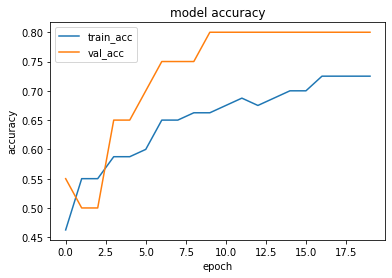

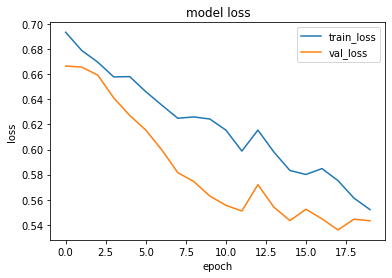

1it [00:00, 14027.77it/s]


prediction for video armflapping_1.mov is [[0.23819458]]


1it [00:00, 19972.88it/s]


prediction for video armflapping_3.mov is [[0.5946517]]


1it [00:00, 19878.22it/s]


prediction for video armflapping_2.mov is [[0.2004542]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.05254403]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.82288575]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.3453995]]
Epoch 1/75
3/3 [==============================] - 1s 228ms/step - loss: 0.7049 - accuracy: 0.3750 - precision_35: 0.3226 - recall_35: 0.2564 - val_loss: 0.6869 - val_accuracy: 0.5000 - val_precision_35: 0.5385 - val_recall_35: 0.6364
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6846 - accuracy: 0.5125 - precision_35: 0.5000 - recall_35: 0.7436 - val_loss: 0.6817 - val_accuracy: 0.5500 - val_precision_35: 0.5625 - val_recall_35: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6770 - accuracy: 0.4875 - precision_35: 0.4844 - recall_35: 0.7949 - val_loss: 0.6820 - val_accuracy: 0.6000 - val_precision_35: 0.5789 - val_recall_35: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6465 - accuracy: 0.5750 - precision_35: 0.5362 - recall_35: 0.9487 - val_loss: 0.6865 - val_accuracy: 0.6000 - val_precision_35: 0.6000 - val_recall_35: 0.8182
Epoch 5/75
3

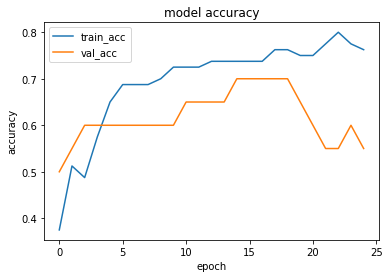

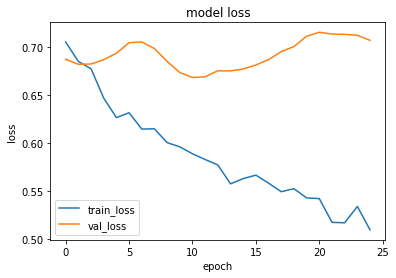

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.24865666]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.5813276]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.2256164]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.11598659]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.9191643]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.20944148]]


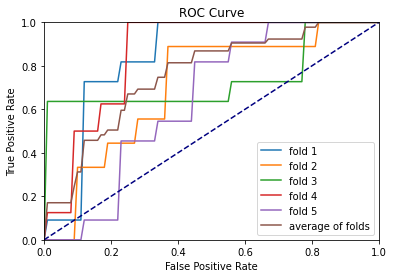

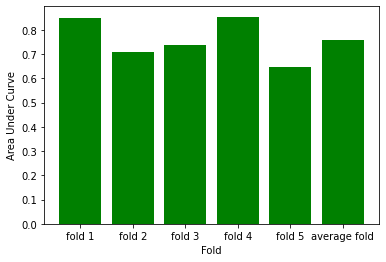

In [28]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 236ms/step - loss: 0.7085 - accuracy: 0.4125 - precision_37: 0.4000 - recall_37: 0.4103 - val_loss: 0.6933 - val_accuracy: 0.3500 - val_precision_37: 0.4375 - val_recall_37: 0.6364
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.7000 - accuracy: 0.4625 - precision_37: 0.4600 - recall_37: 0.5897 - val_loss: 0.6828 - val_accuracy: 0.7500 - val_precision_37: 0.8000 - val_recall_37: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6869 - accuracy: 0.6125 - precision_37: 0.5800 - recall_37: 0.7436 - val_loss: 0.6751 - val_accuracy: 0.7000 - val_precision_37: 0.7778 - val_recall_37: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6654 - accuracy: 0.6250 - precision_37: 0.5882 - recall_37: 0.7692 - val_loss: 0.6676 - val_accuracy: 0.7000 - val_precision_37: 0.7778 - val_recall_37: 0.6364
Epoch 5/75
3/3 [==============================] - 0s 149ms/step 

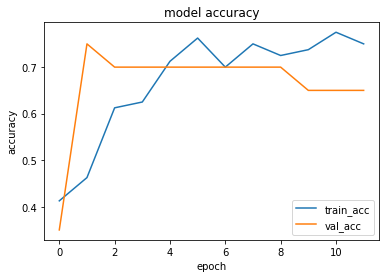

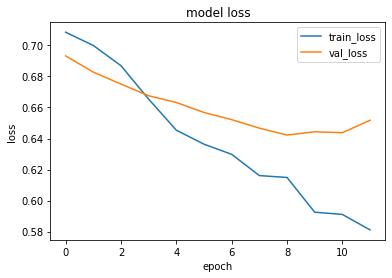

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.52224815]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.50444597]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.53478146]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.44838166]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.53024435]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.5051783]]
Epoch 1/75
3/3 [==============================] - 1s 212ms/step - loss: 0.6914 - accuracy: 0.5250 - precision_38: 0.5195 - recall_38: 0.9756 - val_loss: 0.6906 - val_accuracy: 0.6500 - val_precision_38: 0.5714 - val_recall_38: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6675 - accuracy: 0.6625 - precision_38: 0.6207 - recall_38: 0.8780 - val_loss: 0.6777 - val_accuracy: 0.7000 - val_precision_38: 0.6154 - val_recall_38: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6365 - accuracy: 0.7250 - precision_38: 0.6792 - recall_38: 0.8780 - val_loss: 0.6717 - val_accuracy: 0.7000 - val_precision_38: 0.6154 - val_recall_38: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6300 - accuracy: 0.7125 - precision_38: 0.6800 - recall_38: 0.8293 - val_loss: 0.6651 - val_accuracy: 0.7000 - val_precision_38: 0.6154 - val_recall_38: 0.8889
Epoch 5/75
3

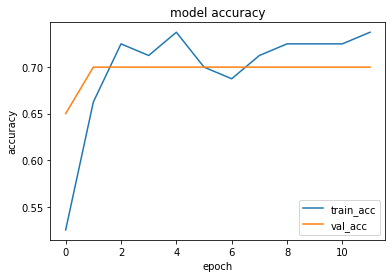

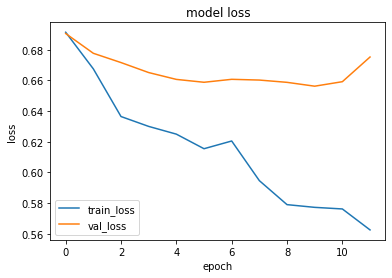

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.25696716]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.60451704]]


1it [00:00, 20068.44it/s]


prediction for video armflapping_2.mov is [[0.16681707]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.10587883]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.86467665]]


1it [00:00, 17476.27it/s]


prediction for video control_3.mov is [[0.15563542]]
Epoch 1/75
3/3 [==============================] - 1s 211ms/step - loss: 0.6917 - accuracy: 0.4250 - precision_39: 0.3704 - recall_39: 0.2564 - val_loss: 0.6907 - val_accuracy: 0.5500 - val_precision_39: 1.0000 - val_recall_39: 0.1818
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6748 - accuracy: 0.6125 - precision_39: 0.7500 - recall_39: 0.3077 - val_loss: 0.6779 - val_accuracy: 0.7000 - val_precision_39: 0.8571 - val_recall_39: 0.5455
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6652 - accuracy: 0.6750 - precision_39: 0.7826 - recall_39: 0.4615 - val_loss: 0.6761 - val_accuracy: 0.6500 - val_precision_39: 0.7000 - val_recall_39: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6570 - accuracy: 0.6125 - precision_39: 0.6111 - recall_39: 0.5641 - val_loss: 0.6694 - val_accuracy: 0.6500 - val_precision_39: 0.7000 - val_recall_39: 0.6364
Epoch 5/75


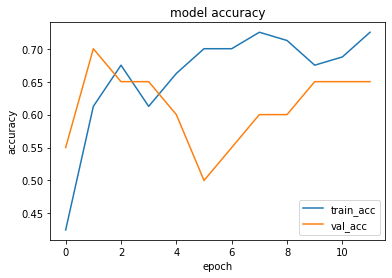

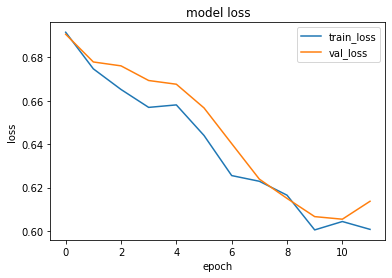

1it [00:00, 19599.55it/s]


prediction for video armflapping_1.mov is [[0.25341916]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.57116604]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.14706352]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.0532051]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.7777444]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.0882265]]
Epoch 1/75
3/3 [==============================] - 1s 202ms/step - loss: 0.6951 - accuracy: 0.6500 - precision_40: 0.6296 - recall_40: 0.8095 - val_loss: 0.7035 - val_accuracy: 0.6500 - val_precision_40: 0.5333 - val_recall_40: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6699 - accuracy: 0.7000 - precision_40: 0.6667 - recall_40: 0.8571 - val_loss: 0.6699 - val_accuracy: 0.7500 - val_precision_40: 0.6154 - val_recall_40: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6659 - accuracy: 0.6750 - precision_40: 0.6481 - recall_40: 0.8333 - val_loss: 0.6527 - val_accuracy: 0.8000 - val_precision_40: 0.6667 - val_recall_40: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6655 - accuracy: 0.6750 - precision_40: 0.6600 - recall_40: 0.7857 - val_loss: 0.6354 - val_accuracy: 0.8000 - val_precision_40: 0.6667 - val_recall_40: 1.0000
Epoch 5/75
3

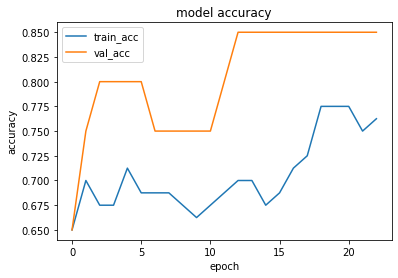

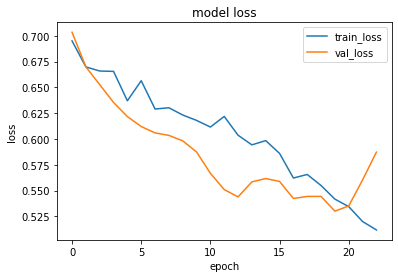

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.4024755]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.5413433]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.31567448]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.16822156]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.7916397]]


1it [00:00, 19239.93it/s]


prediction for video control_3.mov is [[0.25411904]]
Epoch 1/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6813 - accuracy: 0.6125 - precision_41: 0.5714 - recall_41: 0.8205 - val_loss: 0.6917 - val_accuracy: 0.6000 - val_precision_41: 0.6000 - val_recall_41: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6657 - accuracy: 0.7125 - precision_41: 0.6538 - recall_41: 0.8718 - val_loss: 0.6940 - val_accuracy: 0.6000 - val_precision_41: 0.6000 - val_recall_41: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6396 - accuracy: 0.6875 - precision_41: 0.6296 - recall_41: 0.8718 - val_loss: 0.7009 - val_accuracy: 0.6000 - val_precision_41: 0.6000 - val_recall_41: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6317 - accuracy: 0.7375 - precision_41: 0.6731 - recall_41: 0.8974 - val_loss: 0.7071 - val_accuracy: 0.6000 - val_precision_41: 0.6000 - val_recall_41: 0.8182
Epoch 5/75


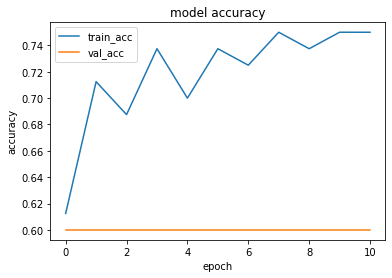

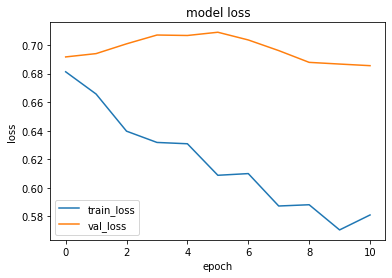

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.38101673]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.5952857]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.27924275]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.1250746]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.8568274]]


1it [00:00, 18236.10it/s]

prediction for video control_3.mov is [[0.17029276]]


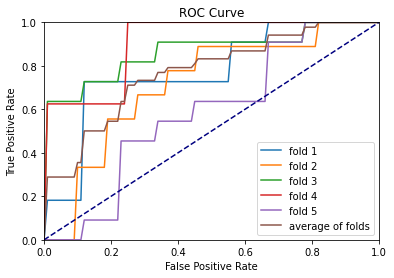

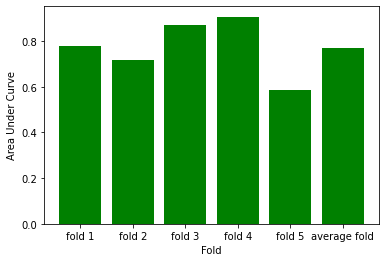

In [29]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 242ms/step - loss: 0.6951 - accuracy: 0.5750 - precision_43: 0.8571 - recall_43: 0.1538 - val_loss: 0.6956 - val_accuracy: 0.6000 - val_precision_43: 0.8000 - val_recall_43: 0.3636
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6892 - accuracy: 0.6375 - precision_43: 0.6471 - recall_43: 0.5641 - val_loss: 0.6780 - val_accuracy: 0.7000 - val_precision_43: 0.7778 - val_recall_43: 0.6364
Epoch 3/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6705 - accuracy: 0.6750 - precision_43: 0.6226 - recall_43: 0.8462 - val_loss: 0.6636 - val_accuracy: 0.6000 - val_precision_43: 0.6364 - val_recall_43: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6465 - accuracy: 0.6750 - precision_43: 0.6182 - recall_43: 0.8718 - val_loss: 0.6545 - val_accuracy: 0.6500 - val_precision_43: 0.7000 - val_recall_43: 0.6364
Epoch 5/75
3/3 [==============================] - 0s 183ms/step 

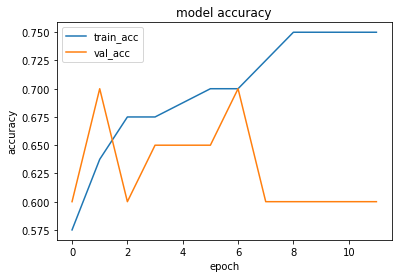

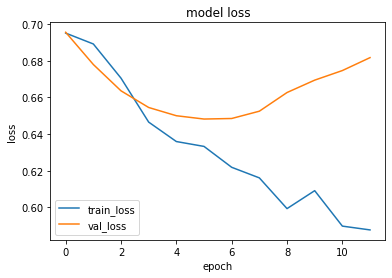

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.49655142]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.5110134]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.47304106]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.38384736]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.5477854]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.40233704]]
Epoch 1/75
3/3 [==============================] - 1s 213ms/step - loss: 0.7097 - accuracy: 0.3625 - precision_44: 0.3214 - recall_44: 0.2195 - val_loss: 0.6824 - val_accuracy: 0.4500 - val_precision_44: 0.4375 - val_recall_44: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6693 - accuracy: 0.5375 - precision_44: 0.5345 - recall_44: 0.7561 - val_loss: 0.6767 - val_accuracy: 0.5000 - val_precision_44: 0.4737 - val_recall_44: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 134ms/step - loss: 0.6592 - accuracy: 0.5250 - precision_44: 0.5211 - recall_44: 0.9024 - val_loss: 0.6742 - val_accuracy: 0.5000 - val_precision_44: 0.4737 - val_recall_44: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6453 - accuracy: 0.5625 - precision_44: 0.5405 - recall_44: 0.9756 - val_loss: 0.6725 - val_accuracy: 0.5000 - val_precision_44: 0.4737 - val_recall_44: 1.0000
Epoch 5/75


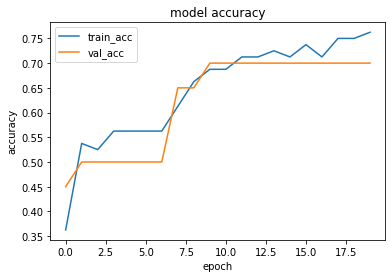

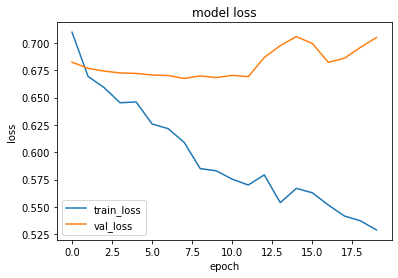

1it [00:00, 19239.93it/s]


prediction for video armflapping_1.mov is [[0.57390517]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5751516]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.4091484]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.12217626]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.87682194]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.59549844]]
Epoch 1/75
3/3 [==============================] - 1s 204ms/step - loss: 0.7060 - accuracy: 0.4750 - precision_45: 0.3636 - recall_45: 0.1026 - val_loss: 0.7117 - val_accuracy: 0.4500 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6944 - accuracy: 0.6000 - precision_45: 0.8182 - recall_45: 0.2308 - val_loss: 0.6964 - val_accuracy: 0.5500 - val_precision_45: 0.6667 - val_recall_45: 0.3636
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6878 - accuracy: 0.5625 - precision_45: 0.5714 - recall_45: 0.4103 - val_loss: 0.6846 - val_accuracy: 0.4500 - val_precision_45: 0.5000 - val_recall_45: 0.5455
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6703 - accuracy: 0.6375 - precision_45: 0.6042 - recall_45: 0.7436 - val_loss: 0.6861 - val_accuracy: 0.5500 - val_precision_45: 0.5833 - val_recall_45: 0.6364
Epo

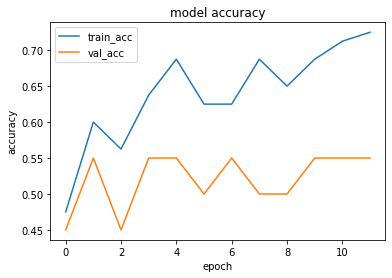

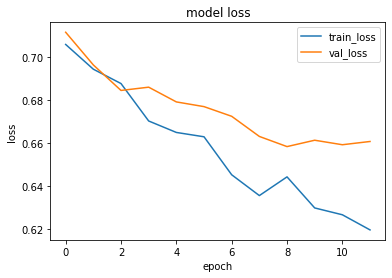

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.36435783]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.5366485]]


1it [00:00, 19599.55it/s]


prediction for video armflapping_2.mov is [[0.21560395]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.10565868]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.65072405]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.13722333]]
Epoch 1/75
3/3 [==============================] - 1s 241ms/step - loss: 0.6769 - accuracy: 0.6250 - precision_46: 0.5909 - recall_46: 0.9286 - val_loss: 0.7022 - val_accuracy: 0.6000 - val_precision_46: 0.5000 - val_recall_46: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6695 - accuracy: 0.6375 - precision_46: 0.6140 - recall_46: 0.8333 - val_loss: 0.6789 - val_accuracy: 0.7000 - val_precision_46: 0.5714 - val_recall_46: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6536 - accuracy: 0.6375 - precision_46: 0.6182 - recall_46: 0.8095 - val_loss: 0.6647 - val_accuracy: 0.7000 - val_precision_46: 0.5714 - val_recall_46: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6462 - accuracy: 0.6625 - precision_46: 0.6316 - recall_46: 0.8571 - val_loss: 0.6583 - val_accuracy: 0.7000 - val_precision_46: 0.5714 - val_recall_46: 1.0000
Epoch 5/75


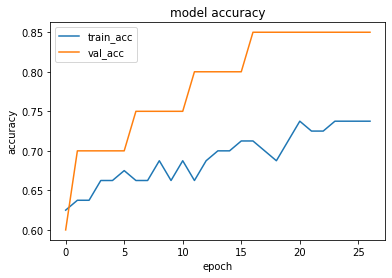

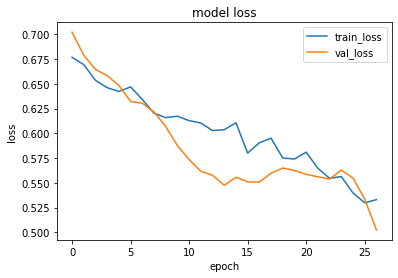

1it [00:00, 19599.55it/s]


prediction for video armflapping_1.mov is [[0.36248323]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5563521]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.22879937]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.1154187]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.8110049]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.24383259]]
Epoch 1/75
3/3 [==============================] - 1s 211ms/step - loss: 0.7239 - accuracy: 0.4625 - precision_47: 0.3333 - recall_47: 0.1026 - val_loss: 0.6915 - val_accuracy: 0.4000 - val_precision_47: 0.4000 - val_recall_47: 0.1818
Epoch 2/75
3/3 [==============================] - 1s 133ms/step - loss: 0.6827 - accuracy: 0.6250 - precision_47: 0.6364 - recall_47: 0.5385 - val_loss: 0.6927 - val_accuracy: 0.6000 - val_precision_47: 0.5789 - val_recall_47: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6679 - accuracy: 0.5750 - precision_47: 0.5373 - recall_47: 0.9231 - val_loss: 0.7009 - val_accuracy: 0.6000 - val_precision_47: 0.5789 - val_recall_47: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6703 - accuracy: 0.5750 - precision_47: 0.5352 - recall_47: 0.9744 - val_loss: 0.7119 - val_accuracy: 0.6000 - val_precision_47: 0.5789 - val_recall_47: 1.0000
Epoch 5/75


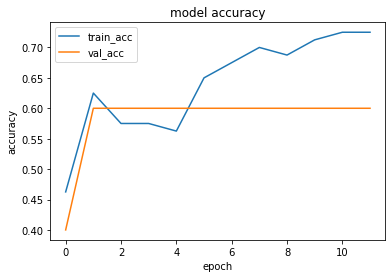

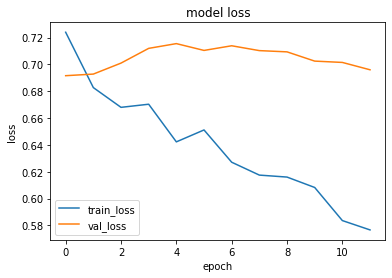

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.38750234]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5989355]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.27673972]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.13603657]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.86401105]]


1it [00:00, 18893.26it/s]

prediction for video control_3.mov is [[0.19160011]]


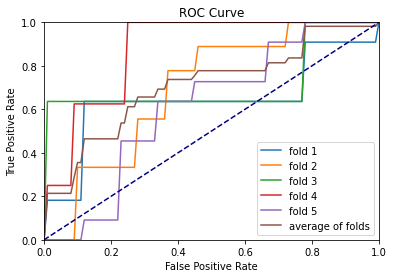

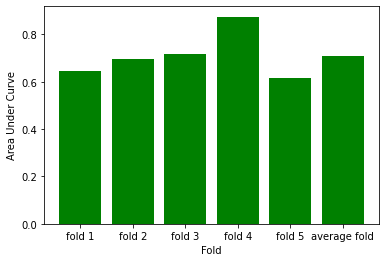

In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 216ms/step - loss: 0.7041 - accuracy: 0.4500 - precision_49: 0.4000 - recall_49: 0.2564 - val_loss: 0.6956 - val_accuracy: 0.4500 - val_precision_49: 0.5000 - val_recall_49: 0.0909
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6817 - accuracy: 0.6125 - precision_49: 0.6818 - recall_49: 0.3846 - val_loss: 0.6892 - val_accuracy: 0.6000 - val_precision_49: 0.8000 - val_recall_49: 0.3636
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6699 - accuracy: 0.6375 - precision_49: 0.6316 - recall_49: 0.6154 - val_loss: 0.6789 - val_accuracy: 0.7000 - val_precision_49: 0.7778 - val_recall_49: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6570 - accuracy: 0.7125 - precision_49: 0.6667 - recall_49: 0.8205 - val_loss: 0.6681 - val_accuracy: 0.7000 - val_precision_49: 0.7778 - val_recall_49: 0.6364
Epoch 5/75
3/3 [==============================] - 0s 131ms/step 

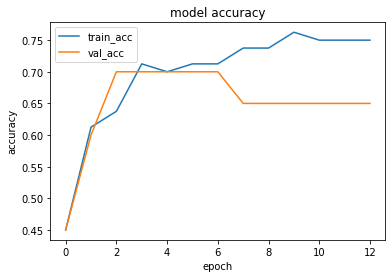

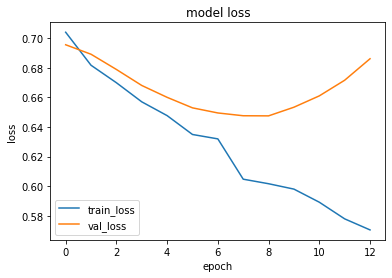

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.45095006]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5056926]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.3998342]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.32999122]]


1it [00:00, 22192.08it/s]


prediction for video control_2.mov is [[0.5407747]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.36663675]]
Epoch 1/75
3/3 [==============================] - 1s 216ms/step - loss: 0.7284 - accuracy: 0.4125 - precision_50: 0.3500 - recall_50: 0.1707 - val_loss: 0.6908 - val_accuracy: 0.3500 - val_precision_50: 0.2500 - val_recall_50: 0.2222
Epoch 2/75
3/3 [==============================] - 1s 128ms/step - loss: 0.6815 - accuracy: 0.4125 - precision_50: 0.4211 - recall_50: 0.3902 - val_loss: 0.6866 - val_accuracy: 0.5000 - val_precision_50: 0.4737 - val_recall_50: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6598 - accuracy: 0.5875 - precision_50: 0.5588 - recall_50: 0.9268 - val_loss: 0.6859 - val_accuracy: 0.5000 - val_precision_50: 0.4737 - val_recall_50: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6691 - accuracy: 0.5250 - precision_50: 0.5205 - recall_50: 0.9268 - val_loss: 0.6878 - val_accuracy: 0.4500 - val_precision_50: 0.4500 - val_recall_50: 1.0000
Epoch 5/75


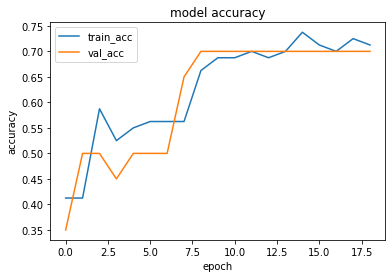

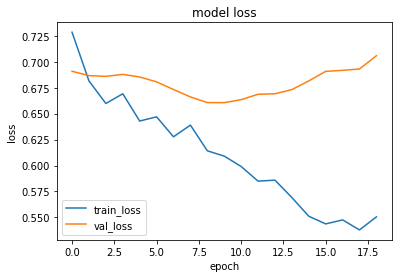

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.796574]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.6071685]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.5906995]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.05450401]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.8831485]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.43924147]]
Epoch 1/75
3/3 [==============================] - 1s 209ms/step - loss: 0.7093 - accuracy: 0.5500 - precision_51: 0.5455 - recall_51: 0.4615 - val_loss: 0.6796 - val_accuracy: 0.7000 - val_precision_51: 1.0000 - val_recall_51: 0.4545
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6868 - accuracy: 0.5875 - precision_51: 0.6000 - recall_51: 0.4615 - val_loss: 0.6775 - val_accuracy: 0.7500 - val_precision_51: 1.0000 - val_recall_51: 0.5455
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6734 - accuracy: 0.6250 - precision_51: 0.6667 - recall_51: 0.4615 - val_loss: 0.6727 - val_accuracy: 0.7500 - val_precision_51: 1.0000 - val_recall_51: 0.5455
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6751 - accuracy: 0.5500 - precision_51: 0.5455 - recall_51: 0.4615 - val_loss: 0.6773 - val_accuracy: 0.7500 - val_precision_51: 1.0000 - val_recall_51: 0.5455
Epoch 5/75


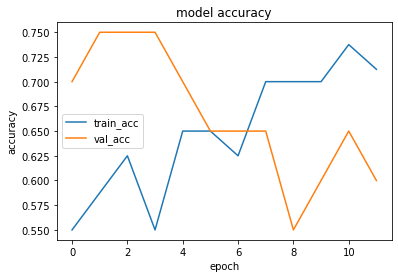

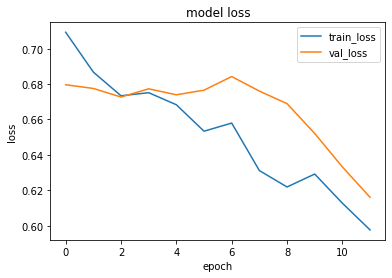

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.47402817]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.49444246]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.41081175]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.40188652]]


1it [00:00, 19691.57it/s]


prediction for video control_2.mov is [[0.5387285]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.41287243]]
Epoch 1/75
3/3 [==============================] - 1s 211ms/step - loss: 0.6858 - accuracy: 0.5125 - precision_52: 0.5217 - recall_52: 0.8571 - val_loss: 0.6797 - val_accuracy: 0.4500 - val_precision_52: 0.4211 - val_recall_52: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6762 - accuracy: 0.5500 - precision_52: 0.5405 - recall_52: 0.9524 - val_loss: 0.6573 - val_accuracy: 0.7500 - val_precision_52: 0.6154 - val_recall_52: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6647 - accuracy: 0.6625 - precision_52: 0.6316 - recall_52: 0.8571 - val_loss: 0.6464 - val_accuracy: 0.8000 - val_precision_52: 0.6667 - val_recall_52: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6629 - accuracy: 0.6625 - precision_52: 0.6415 - recall_52: 0.8095 - val_loss: 0.6358 - val_accuracy: 0.8000 - val_precision_52: 0.6667 - val_recall_52: 1.0000
Epoch 5/75


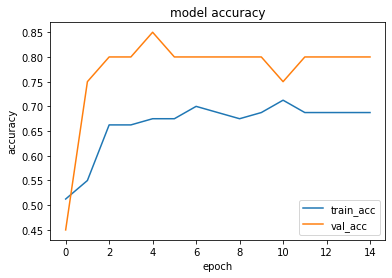

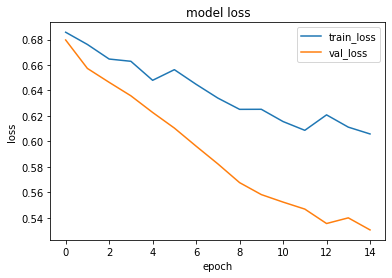

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.57665473]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.52126616]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_2.mov is [[0.53669214]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.35132915]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.6617296]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.43947598]]
Epoch 1/75
3/3 [==============================] - 1s 208ms/step - loss: 0.6839 - accuracy: 0.6375 - precision_53: 0.6316 - recall_53: 0.6154 - val_loss: 0.6845 - val_accuracy: 0.6000 - val_precision_53: 0.6000 - val_recall_53: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6747 - accuracy: 0.7000 - precision_53: 0.6531 - recall_53: 0.8205 - val_loss: 0.6876 - val_accuracy: 0.6000 - val_precision_53: 0.6000 - val_recall_53: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6538 - accuracy: 0.7125 - precision_53: 0.6538 - recall_53: 0.8718 - val_loss: 0.6922 - val_accuracy: 0.6000 - val_precision_53: 0.6000 - val_recall_53: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6392 - accuracy: 0.7250 - precision_53: 0.6604 - recall_53: 0.8974 - val_loss: 0.6872 - val_accuracy: 0.6000 - val_precision_53: 0.6000 - val_recall_53: 0.8182
Epoch 5/75


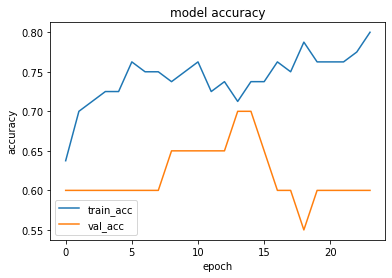

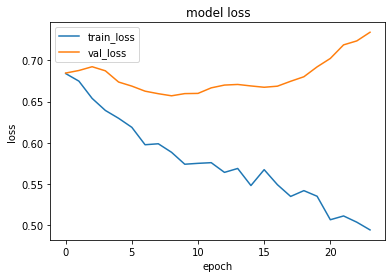

1it [00:00, 19599.55it/s]


prediction for video armflapping_1.mov is [[0.22020742]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_3.mov is [[0.5799173]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.17894208]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.13667485]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.927494]]


1it [00:00, 18236.10it/s]

prediction for video control_3.mov is [[0.14113891]]


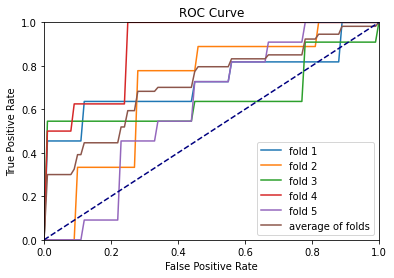

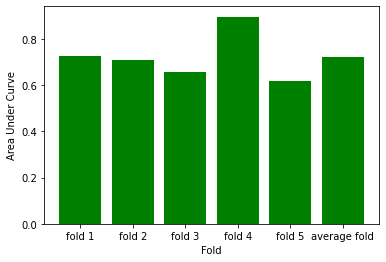

In [32]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.6855 - accuracy: 0.4875 - precision_55: 0.4783 - recall_55: 0.5641 - val_loss: 0.6867 - val_accuracy: 0.4500 - val_precision_55: 0.5000 - val_recall_55: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6642 - accuracy: 0.6000 - precision_55: 0.5593 - recall_55: 0.8462 - val_loss: 0.6695 - val_accuracy: 0.6500 - val_precision_55: 0.7000 - val_recall_55: 0.6364
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6664 - accuracy: 0.6125 - precision_55: 0.5714 - recall_55: 0.8205 - val_loss: 0.6582 - val_accuracy: 0.7000 - val_precision_55: 0.7778 - val_recall_55: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6400 - accuracy: 0.6875 - precision_55: 0.6250 - recall_55: 0.8974 - val_loss: 0.6513 - val_accuracy: 0.7000 - val_precision_55: 0.7778 - val_recall_55: 0.6364
Epoch 5/75
3/3 [==============================] - 0s 131ms/step 

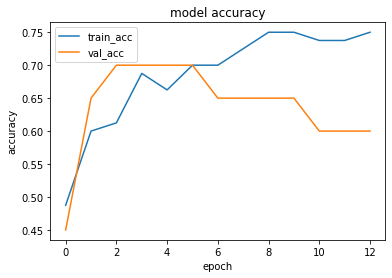

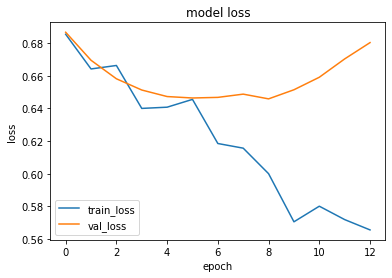

1it [00:00, 19508.39it/s]


prediction for video armflapping_1.mov is [[0.5276795]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.53601843]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.49756378]]


1it [00:00, 19972.88it/s]


prediction for video control_1.mov is [[0.37080598]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.6077538]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.41767016]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.7262 - accuracy: 0.4500 - precision_56: 0.3846 - recall_56: 0.1220 - val_loss: 0.6876 - val_accuracy: 0.4000 - val_precision_56: 0.3333 - val_recall_56: 0.3333
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6914 - accuracy: 0.3750 - precision_56: 0.4082 - recall_56: 0.4878 - val_loss: 0.6788 - val_accuracy: 0.5000 - val_precision_56: 0.4706 - val_recall_56: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6658 - accuracy: 0.5625 - precision_56: 0.5455 - recall_56: 0.8780 - val_loss: 0.6757 - val_accuracy: 0.5000 - val_precision_56: 0.4737 - val_recall_56: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6562 - accuracy: 0.5500 - precision_56: 0.5333 - recall_56: 0.9756 - val_loss: 0.6759 - val_accuracy: 0.5000 - val_precision_56: 0.4737 - val_recall_56: 1.0000
Epoch 5/75


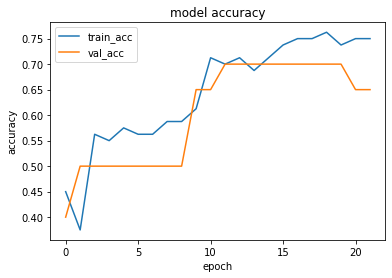

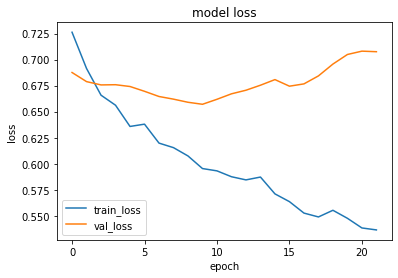

1it [00:00, 16710.37it/s]


prediction for video armflapping_1.mov is [[0.3715099]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.5889519]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.31316328]]


1it [00:00, 18808.54it/s]


prediction for video control_1.mov is [[0.05411652]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.8921186]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.33466944]]
Epoch 1/75
3/3 [==============================] - 1s 221ms/step - loss: 0.7032 - accuracy: 0.4375 - precision_57: 0.4286 - recall_57: 0.4615 - val_loss: 0.6747 - val_accuracy: 0.6000 - val_precision_57: 0.5882 - val_recall_57: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6855 - accuracy: 0.6000 - precision_57: 0.5854 - recall_57: 0.6154 - val_loss: 0.6653 - val_accuracy: 0.5500 - val_precision_57: 0.5833 - val_recall_57: 0.6364
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6754 - accuracy: 0.6250 - precision_57: 0.6364 - recall_57: 0.5385 - val_loss: 0.6611 - val_accuracy: 0.5500 - val_precision_57: 0.5833 - val_recall_57: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6576 - accuracy: 0.6875 - precision_57: 0.6667 - recall_57: 0.7179 - val_loss: 0.6544 - val_accuracy: 0.5500 - val_precision_57: 0.5833 - val_recall_57: 0.6364
Epoch 5/75


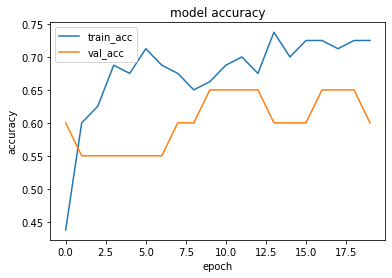

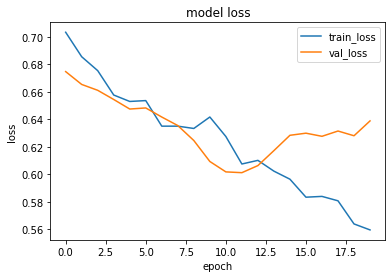

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.20879629]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.60340583]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.12903506]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.05274296]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.7592572]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.08086455]]
Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.6725 - accuracy: 0.6125 - precision_58: 0.5932 - recall_58: 0.8333 - val_loss: 0.7115 - val_accuracy: 0.7000 - val_precision_58: 0.5714 - val_recall_58: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6765 - accuracy: 0.6750 - precision_58: 0.6481 - recall_58: 0.8333 - val_loss: 0.6878 - val_accuracy: 0.7000 - val_precision_58: 0.5714 - val_recall_58: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6698 - accuracy: 0.6750 - precision_58: 0.6538 - recall_58: 0.8095 - val_loss: 0.6670 - val_accuracy: 0.7500 - val_precision_58: 0.6154 - val_recall_58: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6556 - accuracy: 0.7000 - precision_58: 0.6800 - recall_58: 0.8095 - val_loss: 0.6527 - val_accuracy: 0.8000 - val_precision_58: 0.6667 - val_recall_58: 1.0000
Epoch 5/75


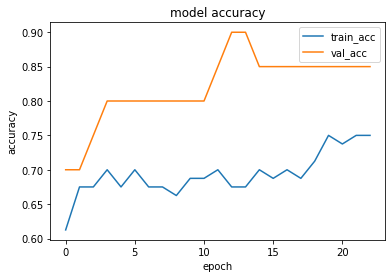

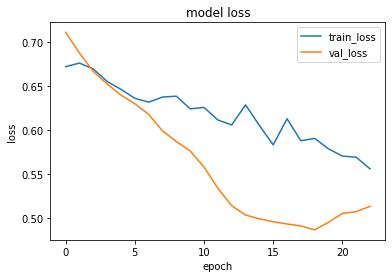

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.40930092]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.5459251]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.30653265]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.1806328]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.7797541]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.24817857]]
Epoch 1/75
3/3 [==============================] - 1s 217ms/step - loss: 0.6745 - accuracy: 0.6750 - precision_59: 0.6182 - recall_59: 0.8718 - val_loss: 0.7070 - val_accuracy: 0.5500 - val_precision_59: 0.5714 - val_recall_59: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6738 - accuracy: 0.7000 - precision_59: 0.6415 - recall_59: 0.8718 - val_loss: 0.7000 - val_accuracy: 0.5500 - val_precision_59: 0.5714 - val_recall_59: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6495 - accuracy: 0.6750 - precision_59: 0.6182 - recall_59: 0.8718 - val_loss: 0.6932 - val_accuracy: 0.5500 - val_precision_59: 0.5714 - val_recall_59: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6464 - accuracy: 0.7000 - precision_59: 0.6531 - recall_59: 0.8205 - val_loss: 0.6936 - val_accuracy: 0.6000 - val_precision_59: 0.6000 - val_recall_59: 0.8182
Epoch 5/75


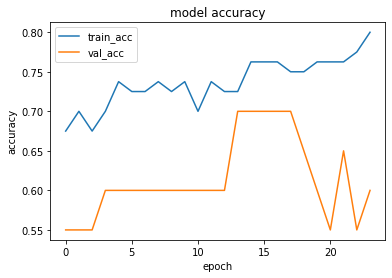

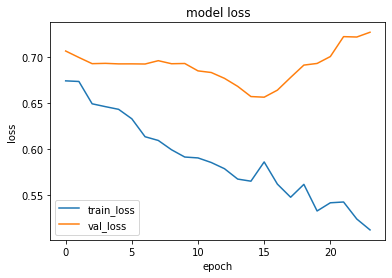

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.35082507]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.59415776]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.27066788]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.12645724]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.92727363]]


1it [00:00, 19239.93it/s]

prediction for video control_3.mov is [[0.22007644]]


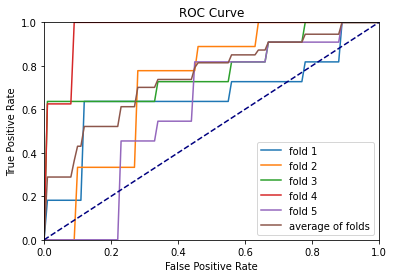

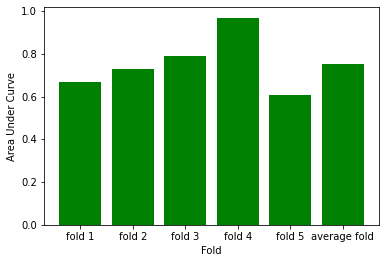

In [33]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 201ms/step - loss: 0.7052 - accuracy: 0.5375 - precision_61: 0.5714 - recall_61: 0.2051 - val_loss: 0.7088 - val_accuracy: 0.5000 - val_precision_61: 1.0000 - val_recall_61: 0.0909
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6882 - accuracy: 0.5750 - precision_61: 0.6667 - recall_61: 0.2564 - val_loss: 0.6910 - val_accuracy: 0.4500 - val_precision_61: 0.5000 - val_recall_61: 0.7273
Epoch 3/75
3/3 [==============================] - 1s 137ms/step - loss: 0.6625 - accuracy: 0.5250 - precision_61: 0.5085 - recall_61: 0.7692 - val_loss: 0.6760 - val_accuracy: 0.5500 - val_precision_61: 0.5556 - val_recall_61: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6479 - accuracy: 0.5500 - precision_61: 0.5217 - recall_61: 0.9231 - val_loss: 0.6633 - val_accuracy: 0.5500 - val_precision_61: 0.5556 - val_recall_61: 0.9091
Epoch 5/75
3/3 [==============================] - 0s 130ms/step 

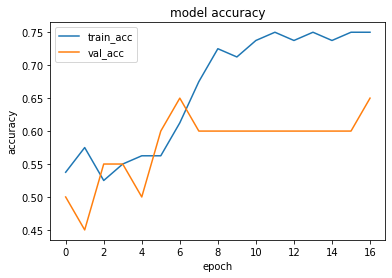

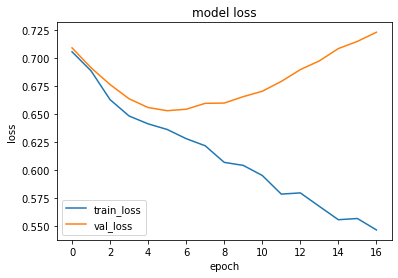

1it [00:00, 17623.13it/s]


prediction for video armflapping_1.mov is [[0.4512952]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5274866]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.35227913]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.19512784]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.71216226]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.28293604]]
Epoch 1/75
3/3 [==============================] - 1s 208ms/step - loss: 0.6858 - accuracy: 0.7250 - precision_62: 0.6939 - recall_62: 0.8293 - val_loss: 0.6849 - val_accuracy: 0.6500 - val_precision_62: 0.5833 - val_recall_62: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6620 - accuracy: 0.7125 - precision_62: 0.6875 - recall_62: 0.8049 - val_loss: 0.6743 - val_accuracy: 0.6500 - val_precision_62: 0.5833 - val_recall_62: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6421 - accuracy: 0.7250 - precision_62: 0.6863 - recall_62: 0.8537 - val_loss: 0.6679 - val_accuracy: 0.7000 - val_precision_62: 0.6154 - val_recall_62: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6329 - accuracy: 0.7250 - precision_62: 0.6863 - recall_62: 0.8537 - val_loss: 0.6618 - val_accuracy: 0.7000 - val_precision_62: 0.6154 - val_recall_62: 0.8889
Epoch 5/75


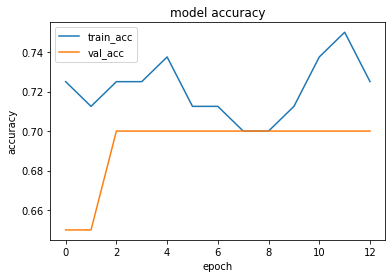

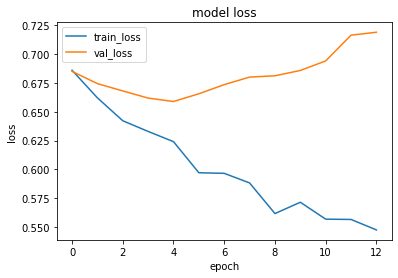

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.5602299]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5194803]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.50880766]]


1it [00:00, 18808.54it/s]


prediction for video control_1.mov is [[0.32790723]]


1it [00:00, 6898.53it/s]


prediction for video control_2.mov is [[0.641645]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.4417921]]
Epoch 1/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6798 - accuracy: 0.5875 - precision_63: 0.5682 - recall_63: 0.6410 - val_loss: 0.6754 - val_accuracy: 0.6000 - val_precision_63: 0.6364 - val_recall_63: 0.6364
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6620 - accuracy: 0.6875 - precision_63: 0.6591 - recall_63: 0.7436 - val_loss: 0.6678 - val_accuracy: 0.5500 - val_precision_63: 0.5833 - val_recall_63: 0.6364
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6584 - accuracy: 0.6500 - precision_63: 0.6341 - recall_63: 0.6667 - val_loss: 0.6714 - val_accuracy: 0.5500 - val_precision_63: 0.5833 - val_recall_63: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6538 - accuracy: 0.6500 - precision_63: 0.6341 - recall_63: 0.6667 - val_loss: 0.6800 - val_accuracy: 0.5500 - val_precision_63: 0.5833 - val_recall_63: 0.6364
Epoch 5/75
3

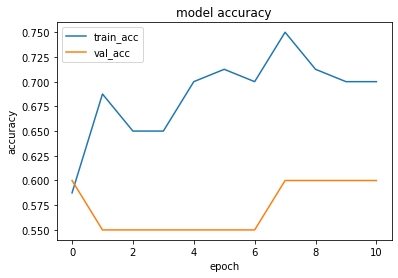

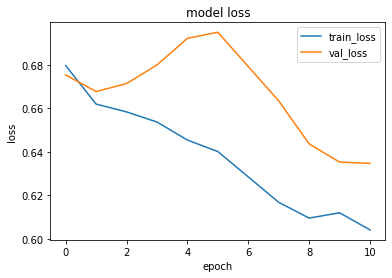

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.42145348]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.5754658]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.21004257]]


1it [00:00, 18641.35it/s]


prediction for video control_1.mov is [[0.06304061]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.76040673]]


1it [00:00, 17260.51it/s]


prediction for video control_3.mov is [[0.11309221]]
Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.6871 - accuracy: 0.6375 - precision_64: 0.6327 - recall_64: 0.7381 - val_loss: 0.7101 - val_accuracy: 0.6500 - val_precision_64: 0.5333 - val_recall_64: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6743 - accuracy: 0.6500 - precision_64: 0.6346 - recall_64: 0.7857 - val_loss: 0.6911 - val_accuracy: 0.7500 - val_precision_64: 0.6154 - val_recall_64: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6651 - accuracy: 0.6500 - precision_64: 0.6346 - recall_64: 0.7857 - val_loss: 0.6729 - val_accuracy: 0.8000 - val_precision_64: 0.6667 - val_recall_64: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6635 - accuracy: 0.6750 - precision_64: 0.6538 - recall_64: 0.8095 - val_loss: 0.6588 - val_accuracy: 0.8000 - val_precision_64: 0.6667 - val_recall_64: 1.0000
Epoch 5/75


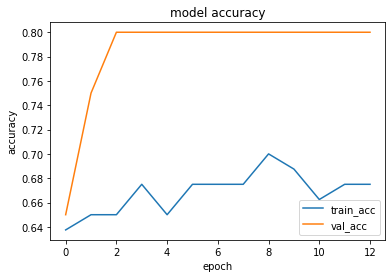

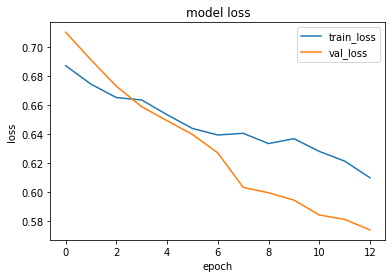

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.5570671]]


1it [00:00, 18315.74it/s]


prediction for video armflapping_3.mov is [[0.50940144]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.5146086]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.47409347]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.6331463]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.4687592]]
Epoch 1/75
3/3 [==============================] - 1s 211ms/step - loss: 0.6797 - accuracy: 0.5125 - precision_65: 0.5000 - recall_65: 0.7692 - val_loss: 0.6875 - val_accuracy: 0.6000 - val_precision_65: 0.6000 - val_recall_65: 0.8182
Epoch 2/75
3/3 [==============================] - 1s 132ms/step - loss: 0.6670 - accuracy: 0.6375 - precision_65: 0.5893 - recall_65: 0.8462 - val_loss: 0.6885 - val_accuracy: 0.6000 - val_precision_65: 0.6000 - val_recall_65: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6430 - accuracy: 0.7000 - precision_65: 0.6364 - recall_65: 0.8974 - val_loss: 0.6881 - val_accuracy: 0.6000 - val_precision_65: 0.6000 - val_recall_65: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6334 - accuracy: 0.6875 - precision_65: 0.6346 - recall_65: 0.8462 - val_loss: 0.6892 - val_accuracy: 0.6000 - val_precision_65: 0.6000 - val_recall_65: 0.8182
Epoch 5/75
3

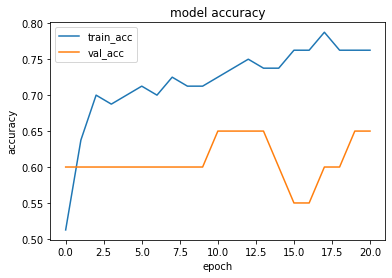

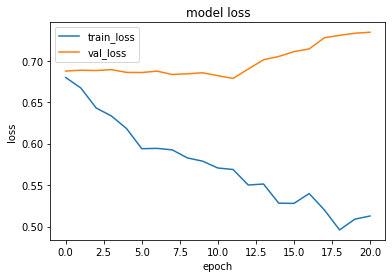

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.27693346]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.5917955]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_2.mov is [[0.33201772]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.05202317]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.92716193]]


1it [00:00, 18558.87it/s]

prediction for video control_3.mov is [[0.32770848]]


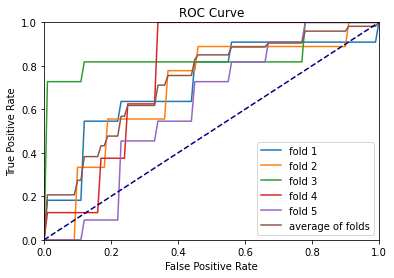

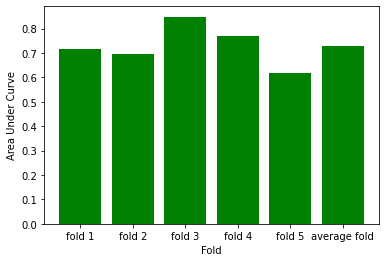

In [34]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])